# GPS Data Prep and Manip
Load in the raw data from Steve and manip it into vectors for the K-D tree

https://github.com/balarsen/GPSFluxForecast/commit/83073aadd7d2d85977f03e60c95b0f492fd1f0a7

Data: initial commit of pre-processed CXD data

Data source is the initial public release of CXD data (v1.03)
indexed at data.gov. The data are binned in time and McIlwain L
and then the slice between L=4.25 and L=4.5 is taken for 3 energies.
This file has 0.425MeV, 1MeV and 1.6 MeV. These were the data
presented by Morley et al. at the 2016 Fall AGU meeting (abstract
archived by NASA ADS with bibcode 2016AGUFMSM23C..07M). The time bin
is 8 hours. All available CXD data in each bin have been averaged
to obtain the mean flux. No data cleaning was performed prior to the
binning/averaging.

In [1]:
%load_ext version_information

In [2]:
import datetime
from pprint import pprint
from itertools import tee

import spacepy.plot as spp
import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import omni
from spacepy import time as spt
from spacepy import plot as spp
spp.revert_style()
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import tqdm
from scipy import stats
import matplotlib
from sklearn.neighbors import KDTree
import tqdm 
from spacepy import omni as omni
from spacepy import toolbox as tb
from spacepy import time as spt
from spacepy import datamodel as dm
import scipy

import verify

%version_information numpy, matplotlib, version_information, verify, scipy, sklearn, seaborn, spacepy

This unreleased version of SpacePy is not supported by the SpacePy team.


Software,Version
Python,3.7.0 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.2.0
OS,Darwin 17.7.0 x86_64 i386 64bit
numpy,1.15.4
matplotlib,3.0.2
version_information,1.0.3
verify,The 'verify' distribution was not found and is required by the application
scipy,1.1.0
sklearn,0.20.1
seaborn,0.9.0


## Load the CXD data

* Load the data
    * do any needed cleaning (none needed)
    * change times form bin centers to bin starts
* Fill in the K-D tree
* Prove we have it loaded right

In [3]:
CXD_dfile = '../Data/CXDdata_L4p25toL4p5.h5'
CXD = dm.fromHDF5(CXD_dfile)
CXD.tree(verbose=1)

+
|____Flux_0.425 (spacepy.datamodel.dmarray (17349,))
|____Flux_1.0 (spacepy.datamodel.dmarray (17349,))
|____Flux_1.6 (spacepy.datamodel.dmarray (17349,))
|____UTC (spacepy.datamodel.dmarray (17349,))


In [4]:
CXD['UTC'][0:5]

dmarray([b'2001-01-01T04:00:00', b'2001-01-01T12:00:00',
         b'2001-01-01T20:00:00', b'2001-01-02T04:00:00',
         b'2001-01-02T12:00:00'], dtype='|S35')

In [5]:
pd.DatetimeIndex(np.asarray(CXD['UTC'][0:5], dtype=str))

DatetimeIndex(['2001-01-01 04:00:00', '2001-01-01 12:00:00',
               '2001-01-01 20:00:00', '2001-01-02 04:00:00',
               '2001-01-02 12:00:00'],
              dtype='datetime64[ns]', freq=None)

In [6]:
CXD = pd.DataFrame({'Flux_1.6':CXD['Flux_1.6']}, index=pd.DatetimeIndex(np.asarray(CXD['UTC'], dtype=str)))
CXD.dropna(inplace=True)
CXD.head()

,Flux_1.6
2001-02-20 12:00:00,43069.021355
2001-02-20 20:00:00,27193.231000
2001-02-21 04:00:00,14515.348125
2001-02-21 12:00:00,24432.734140
2001-02-21 20:00:00,23571.599474


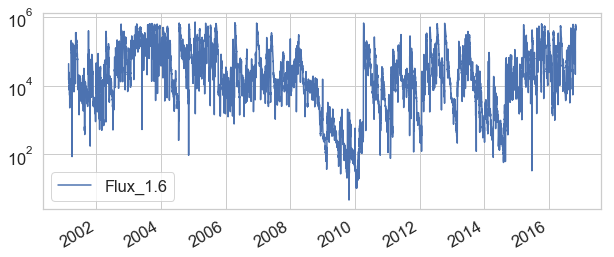

In [7]:
CXD.plot(logy=True, figsize=(10,4))

### Look for bad data

In [8]:
CXD.isna().sum()
# there are 0 nans in the dataset

Flux_1.6    0
dtype: int64

In [9]:
CXD.min()
# min makes sense

Flux_1.6    4.711297
dtype: float64

In [10]:
CXD.max()
# max makes sense

Flux_1.6    701504.594737
dtype: float64

Standardize the fluxes 

$\frac{f-<f>}{\sigma_f}$

In [11]:
CXD['Log_Flux_1.6'] = np.log10(CXD['Flux_1.6'])
std_mean = CXD['Log_Flux_1.6'].mean()
std_std = CXD['Log_Flux_1.6'].std()
CXD['Log_Flux_1.6_std'] = (CXD['Log_Flux_1.6']-std_mean)/std_std
CXD.head()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-20 12:00:00,43069.021355,4.634165,0.471567
2001-02-20 20:00:00,27193.231000,4.434461,0.254677
2001-02-21 04:00:00,14515.348125,4.161827,-0.041419
2001-02-21 12:00:00,24432.734140,4.387972,0.204187
2001-02-21 20:00:00,23571.599474,4.372389,0.187263


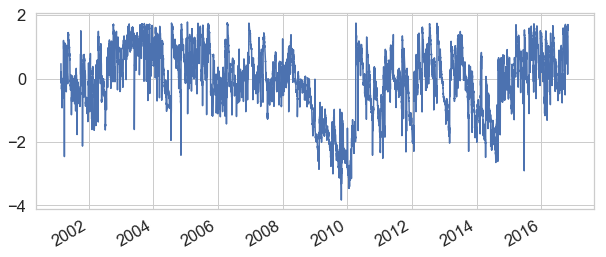

In [12]:
CXD['Log_Flux_1.6_std'].plot(logy=False, figsize=(10,4))

In [13]:
CXD.describe()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
count,16608.000000,16608.000000,1.660800e+04
mean,68851.601989,4.199964,1.334835e-16
std,114299.012349,0.920762,1.000000e+00
min,4.711297,0.673140,-3.830331e+00
25%,5280.980400,3.722714,-5.183203e-01
50%,19360.543882,4.286918,9.443633e-02
75%,75268.222359,4.876612,7.348776e-01
max,701504.594737,5.846031,1.787722e+00


In [14]:
16608*8/24/365, 'years'

(15.167123287671233, 'years')

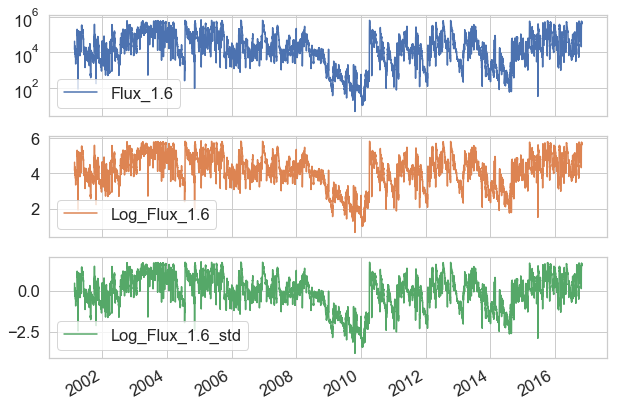

In [15]:
ax = CXD.plot(logy=False, subplots=True, figsize=(10,7))
ax[0].set_yscale('log')

### Change bin center times to bin start times
Makes it easier to pull out data between stamps

In [16]:
CXD.index -= datetime.timedelta(hours=4)
CXD.sort_index(inplace=True)    # make sure it is sorted (should already be)
CXD.head()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-20 08:00:00,43069.021355,4.634165,0.471567
2001-02-20 16:00:00,27193.231000,4.434461,0.254677
2001-02-21 00:00:00,14515.348125,4.161827,-0.041419
2001-02-21 08:00:00,24432.734140,4.387972,0.204187
2001-02-21 16:00:00,23571.599474,4.372389,0.187263


In [17]:
pd.isna(CXD['Log_Flux_1.6_std']).sum()

0

In [18]:
CXD['Log_Flux_1.6_std'].min()

-3.830330734760265

In [ ]:
CXD.loc['2001-02-24':'2001-02-28']
# there are gaps

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-24 00:00:00,13491.928750,4.130074,-0.075905
2001-02-25 16:00:00,16984.478000,4.230052,0.032677
2001-02-26 00:00:00,15425.448333,4.188238,-0.012735
2001-02-26 08:00:00,16233.831290,4.210421,0.011357
2001-02-26 16:00:00,9499.718200,3.977711,-0.241380
2001-02-27 00:00:00,7908.678786,3.898104,-0.327837
2001-02-27 08:00:00,8276.462043,3.917845,-0.306398
2001-02-27 16:00:00,8750.426778,3.942029,-0.280132
2001-02-28 00:00:00,10083.422333,4.003608,-0.213254
2001-02-28 08:00:00,10350.411926,4.014958,-0.200928


## Create a time index for the whole time and look for missing times

In [ ]:
# this is all the possible time stamps
ind = pd.DatetimeIndex(start=CXD.index[0], end=CXD.index[-1], freq='8H')
dftmp = pd.DataFrame({v:np.nan for v in CXD.columns}, index=ind)
# put them all into the CXD df
CXD = pd.concat([CXD, dftmp])
CXD = CXD[~CXD.index.duplicated(keep='first')]
CXD.sort_index(inplace=True)

In [ ]:
pd.isna(CXD['Log_Flux_1.6_std']).sum()
# there are 590 missing times in the dataset

590

In [ ]:
CXD.loc['2001-02-24':'2001-02-28']

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-24 00:00:00,13491.928750,4.130074,-0.075905
2001-02-24 08:00:00,NaN,NaN,NaN
2001-02-24 16:00:00,NaN,NaN,NaN
2001-02-25 00:00:00,NaN,NaN,NaN
2001-02-25 08:00:00,NaN,NaN,NaN
2001-02-25 16:00:00,16984.478000,4.230052,0.032677
2001-02-26 00:00:00,15425.448333,4.188238,-0.012735
2001-02-26 08:00:00,16233.831290,4.210421,0.011357
2001-02-26 16:00:00,9499.718200,3.977711,-0.241380
2001-02-27 00:00:00,7908.678786,3.898104,-0.327837


In [ ]:
CXD.loc[CXD['Log_Flux_1.6_std'].isna()]

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-24 08:00:00,NaN,NaN,NaN
2001-02-24 16:00:00,NaN,NaN,NaN
2001-02-25 00:00:00,NaN,NaN,NaN
2001-02-25 08:00:00,NaN,NaN,NaN
2001-03-12 08:00:00,NaN,NaN,NaN
2001-03-19 08:00:00,NaN,NaN,NaN
2001-03-19 16:00:00,NaN,NaN,NaN
2001-03-20 00:00:00,NaN,NaN,NaN
2001-03-20 08:00:00,NaN,NaN,NaN
2001-03-29 00:00:00,NaN,NaN,NaN


### Interpolate over gaps 1 data point wide
* Looks like are 590 points

In [ ]:
CXD.describe()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
count,16608.000000,16608.000000,1.660800e+04
mean,68851.601989,4.199964,1.677100e-16
std,114299.012349,0.920762,1.000000e+00
min,4.711297,0.673140,-3.830331e+00
25%,5280.980400,3.722714,-5.183203e-01
50%,19360.543882,4.286918,9.443633e-02
75%,75268.222359,4.876612,7.348776e-01
max,701504.594737,5.846031,1.787722e+00


In [ ]:
# this is all the possible time stamps
ind = pd.DatetimeIndex(start=CXD.index[0], end=CXD.index[-1], freq='8H')
dftmp = pd.DataFrame({v:np.nan for v in CXD.columns}, index=ind)
# put them all into the CXD df
CXD = pd.concat([CXD, dftmp])
CXD = CXD[~CXD.index.duplicated(keep='first')]
CXD.sort_index(inplace=True)

In [ ]:
CXD.head()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-20 08:00:00,43069.021355,4.634165,0.471567
2001-02-20 16:00:00,27193.231000,4.434461,0.254677
2001-02-21 00:00:00,14515.348125,4.161827,-0.041419
2001-02-21 08:00:00,24432.734140,4.387972,0.204187
2001-02-21 16:00:00,23571.599474,4.372389,0.187263


In [ ]:
CXD.describe()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
count,16608.000000,16608.000000,1.660800e+04
mean,68851.601989,4.199964,1.677100e-16
std,114299.012349,0.920762,1.000000e+00
min,4.711297,0.673140,-3.830331e+00
25%,5280.980400,3.722714,-5.183203e-01
50%,19360.543882,4.286918,9.443633e-02
75%,75268.222359,4.876612,7.348776e-01
max,701504.594737,5.846031,1.787722e+00


In [ ]:
CXD.isna().sum()

Flux_1.6            590
Log_Flux_1.6        590
Log_Flux_1.6_std    590
dtype: int64

In [ ]:
CXD.loc[CXD.isna()['Flux_1.6']].head()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-24 08:00:00,NaN,NaN,NaN
2001-02-24 16:00:00,NaN,NaN,NaN
2001-02-25 00:00:00,NaN,NaN,NaN
2001-02-25 08:00:00,NaN,NaN,NaN
2001-03-12 08:00:00,NaN,NaN,NaN


In [ ]:
CXD.loc['2001-02-24 00:00:00':'2001-02-27 08:00:00']

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-24 00:00:00,13491.928750,4.130074,-0.075905
2001-02-24 08:00:00,NaN,NaN,NaN
2001-02-24 16:00:00,NaN,NaN,NaN
2001-02-25 00:00:00,NaN,NaN,NaN
2001-02-25 08:00:00,NaN,NaN,NaN
2001-02-25 16:00:00,16984.478000,4.230052,0.032677
2001-02-26 00:00:00,15425.448333,4.188238,-0.012735
2001-02-26 08:00:00,16233.831290,4.210421,0.011357
2001-02-26 16:00:00,9499.718200,3.977711,-0.241380
2001-02-27 00:00:00,7908.678786,3.898104,-0.327837


In [ ]:
CXD.interpolate(method='index', axis=0, limit=1, inplace=True)
CXD.isna().sum()

Flux_1.6            186
Log_Flux_1.6        186
Log_Flux_1.6_std    186
dtype: int64

# Build the data into vectors 7 days + 1 measurement long
1. Get the start and end times of all the time periods
1. grab all the data in each of those, place into vector
1. increment start by 1 data point and repeat

## Build arrays of all the start/stop times needed to grab the data for vectors

In [ ]:
p1 = pd.DatetimeIndex(start=CXD.index[0], end=CXD.index[-1], freq=datetime.timedelta(days=7, hours=8))
p1[0:5]

DatetimeIndex(['2001-02-20 08:00:00', '2001-02-27 16:00:00',
               '2001-03-07 00:00:00', '2001-03-14 08:00:00',
               '2001-03-21 16:00:00'],
              dtype='datetime64[ns]', freq='176H')

In [ ]:
(p1[1]-p1[0]).total_seconds()/3600/8

22.0

In [ ]:
periods = []
for ii in range(int((p1[1]-p1[0]).total_seconds()/3600/8)):
    periods.append(p1+pd.DateOffset(hours=8*ii))

In [ ]:
len(periods)

22

In [ ]:
# the last periods[-1][0] should be the point before periods[0][1]
for p in periods:
    print(p[:4])
assert (periods[0][1] - periods[-1][0]).total_seconds() == 3600*8

DatetimeIndex(['2001-02-20 08:00:00', '2001-02-27 16:00:00',
               '2001-03-07 00:00:00', '2001-03-14 08:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-02-20 16:00:00', '2001-02-28 00:00:00',
               '2001-03-07 08:00:00', '2001-03-14 16:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-02-21 00:00:00', '2001-02-28 08:00:00',
               '2001-03-07 16:00:00', '2001-03-15 00:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-02-21 08:00:00', '2001-02-28 16:00:00',
               '2001-03-08 00:00:00', '2001-03-15 08:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-02-21 16:00:00', '2001-03-01 00:00:00',
               '2001-03-08 08:00:00', '2001-03-15 16:00:00'],
              dtype='datetime64[ns]', freq='176H')
DatetimeIndex(['2001-02-22 00:00:00', '2001-03-01 08:00:00',
               '2001-03-08 16:00:00', '2001-03-16 00:00:00'],
       

## Using the start/stop times grab all the data and make vectors

In [ ]:
# make a dataframe with the data for the first week, 
# the index is the measurement time, the columns is the hours before the measurement
vector_Log_Flux = pd.DataFrame({v:CXD['Log_Flux_1.6'].iloc[ii] for ii, v in enumerate(range(-176, 1, 8))}, 
                               index=[periods[0][1]])
vector_Log_Flux

,-176,-168,-160,-152,-144,-136,-128,-120,-112,-104,...,-72,-64,-56,-48,-40,-32,-24,-16,-8,0
2001-02-27 16:00:00,4.634165,4.434461,4.161827,4.387972,4.372389,4.387674,4.372046,4.186911,4.07088,4.11198,...,NaN,NaN,NaN,4.230052,4.188238,4.210421,3.977711,3.898104,3.917845,3.942029


In [ ]:
# This can be done much smarter with .loc[]
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

vectors_Log_Flux = []
vectors_Log_Flux_std = []


for p in tqdm.tqdm(periods):
    TMP_DF = pd.DataFrame({v:CXD['Log_Flux_1.6'].iloc[ii] for ii, v in enumerate(range(-176, 1, 8))}, 
                               index=[0])
    TMP_DF_std = pd.DataFrame({v:CXD['Log_Flux_1.6_std'].iloc[ii] for ii, v in enumerate(range(-176, 1, 8))}, 
                               index=[0])
    for t1, t2 in pairwise(p):
        tmpv = CXD['Log_Flux_1.6'].loc[t1:t2].values
        if len(tmpv) != 23:
            continue
        tmpv_std = CXD['Log_Flux_1.6_std'].loc[t1:t2].values
        TMP_DF.loc[t2] = tmpv
        TMP_DF_std.loc[t2] = tmpv_std
    vectors_Log_Flux.append(TMP_DF)
    vectors_Log_Flux_std.append(TMP_DF_std)

vectors_Log_Flux = pd.concat(vectors_Log_Flux)
vectors_Log_Flux.drop(0, inplace=True) # drop the 0 row at the top
vectors_Log_Flux_std = pd.concat(vectors_Log_Flux_std)
vectors_Log_Flux_std.drop(0, inplace=True) # drop the 0 row at the top


 91%|█████████ | 20/22 [00:51<00:05,  2.56s/it]

In [ ]:
vectors_Log_Flux.index = pd.DatetimeIndex(vectors_Log_Flux.index)
vectors_Log_Flux.sort_index(inplace=True)
vectors_Log_Flux_std.index = pd.DatetimeIndex(vectors_Log_Flux_std.index)
vectors_Log_Flux_std.sort_index(inplace=True)

In [ ]:
vectors_Log_Flux.describe()

In [ ]:
vectors_Log_Flux.head()

In [ ]:
# drop any with na
vectors_Log_Flux.dropna(how='any', inplace=True)
vectors_Log_Flux_std.dropna(how='any', inplace=True)

In [ ]:
vectors_Log_Flux.describe()

In [ ]:
vectors_Log_Flux.head()

In [ ]:
vectors_Log_Flux[[-16,-8,0]].loc['2002-01'].plot(figsize=(10,6))


In [ ]:
vectors_Log_Flux.loc['2002-01-31T16:00'].plot(figsize=(10,6))
vectors_Log_Flux.loc['2002-02-1T00:00'].plot(figsize=(10,6))

In [ ]:
vectors_Log_Flux_std[[-16,-8,0]].loc['2002-01'].plot(figsize=(10,6))


In [ ]:
vectors_Log_Flux_std.loc['2002-01-31T16:00'].plot(figsize=(10,6))
vectors_Log_Flux_std.loc['2002-02-1T00:00'].plot(figsize=(10,6))

In [ ]:
vectors_Log_Flux_std.head()

In [ ]:
vectors_Log_Flux_std['std_mean'] = std_mean
vectors_Log_Flux_std['std_std'] = std_std


In [ ]:
vectors_Log_Flux_std.columns

### Time limits of the data:

In [ ]:
vectors_Log_Flux.index[0], vectors_Log_Flux.index[-1], 

# Store the data to disk as an HDF5
read in best with pandas, likely needs pytables

In [ ]:
store = pd.HDFStore('../Data/CXD_Vectors.h5', mode='w', complevel=9)

In [ ]:
store['vectors_Log_Flux'] = vectors_Log_Flux

In [ ]:
store['vectors_Log_Flux_std'] = vectors_Log_Flux_std

In [ ]:
store.close()

### Now store the raw GPS data to disk

In [ ]:
CXD.head()

In [ ]:
store = pd.HDFStore('../Data/CXD_Data.h5', mode='w', complevel=9)
for c in CXD:
    store[c] = CXD[c]
store.close()

# Read the file back and compare

In [ ]:
a = pd.read_hdf('../Data/CXD_Vectors.h5', 'vectors_Log_Flux_std')

In [ ]:
b = pd.read_hdf('../Data/CXD_Vectors.h5', 'vectors_Log_Flux')

In [ ]:
(vectors_Log_Flux_std - a).any()

In [ ]:
(vectors_Log_Flux - b).any()

# Demonstrate how to get the vectors out

In [ ]:
del a, b

## The vector at a time
remember for std drop the last 2

In [ ]:
vectors_Log_Flux_std.loc['2001-03-06T08:00:00']

In [ ]:
vectors_Log_Flux_std.loc['2001-03-06T08:00:00'].values[:-2]